# Barrier swaption

In this section we consider Monte Carlo evaluation of a knock-out swaption
under the LMM. We use the knock-out swaption as a guide in our exposition,
its treatment is rather general and it can be used to value diﬀerent barrier
options, where the underlying and barrier can be expressed as functionals of
some diﬀusion process.

A European payer (receiver) swaption is an option that gives its holder a
right, but not an obligation, to enter a payer (receiver) swap at a future date
at a given fixed rate K. Usually, the swaption maturity coincides with the first
reset date T0 of the underlying swap. The underlying swap length TN− T0 is
called the tenor of the swaption.

$$
V_{\text{swaption}}(0) = P(0, T_0) \, \mathbb{E}^{\mathbb{Q}^{T_0}} \left[
\delta \left( R_{\text{swap}}(T_0) - K \right)_+
\sum_{j=1}^{N} P(T_0, T_j) \, \chi(\theta > T_0)
\right]
\tag{6.1}
$$

where $\theta$ is the first exit time of the process $R_{\text{swap}}(s), s \geq 0$,
from the interval $(0, R_{\text{up}})$.
That is, $\theta$ is the earliest time at which the swap rate crosses the upper barrier $R_{\text{up}}$,
causing the knock-out feature of the swaption to be triggered.

In [17]:
import numpy as np
from scipy.linalg import cholesky
from scipy.optimize import minimize
from tqdm import tqdm
from scipy.stats import norm
import pandas as pd
import scipy.stats as stats
from math import *

from numba import njit, prange

## 0. Setup du modèle

- Nombre de forward rates `N`
- Maturité $(T_0)$ découpée en `M` pas de taille `h`
- Courbe initiale `L0`, volatilités `sigma`
- Corrélation exponentielle $( \rho_{ij} = e^{-\beta|T_i - T_j|} $)

In [18]:
# Paramètres
N     = 10
T0    = 10.0
delta = 1.0
M     = 100
h     = T0 / M
K     = 0.01   # Strike
Rup   = 0.075  # Barrier
L0    = 0.05 * np.ones(N)
sigma = 0.10 * np.ones(N)
beta  = 0.1
T_star= T0 + delta * N

$$
\rho_{i,j} = \exp(-\beta |T_i - T_j|).
\tag{3.6}
$$

Where $U$ is the upper triangular matrix
$$
\rho = UU^\top,
\tag{3.5}
$$

In [19]:
# Corrélation et Cholesky
times = T0 + delta * np.arange(N)       # T_i = T0, T0+δ, …, T0+(N-1)δ
rho   = np.exp(-beta * np.abs(times[:, None] - times[None, :]))
U     = cholesky(rho, lower=False)

# PRICE conventionnel
T0_index = int(T0 / delta)
P0_T0 = np.prod(1.0 / (1 + delta * L0[:T0_index]))

# Matrice précomputée pour drift (i >= j)
full_mat  = rho * np.outer(sigma, sigma)
drift_mat = np.tril(full_mat)           # (i,j) zero if j>i

### Swap Rate Function

The swap rate $R_{swap}(s)$ can be expressed in terms of the spanning LIBOR rates as:

$$
R_{\text{swap}}(s) = \frac{1 - \frac{1}{\prod\limits_{j=0}^{N-1} \left(1 + \delta L^j(s)\right)}}
{\delta \sum\limits_{i=0}^{N-1} \frac{1}{\prod\limits_{j=0}^{i} \left(1 + \delta L^j(s)\right)}}.
\tag{6.2}
$$

In [20]:
def R_swap(logL, delta):
    L = np.exp(logL)
    discount_prod = np.prod(1 + delta * L)
    numer = 1 - 1.0 / discount_prod
    denom = delta * np.sum(1.0 / np.cumprod(1 + delta * L))
    return numer / denom

## 1. Approximation analytique

For test purposes, let us introduce an analytical approximation for the barrier swaption. To this end, we note that under the Swap Market Model (SMM, see details in [4, 18, 21]) the barrier swaption pricing problem admits the closed-form solution (cf. (4.3)):


- La payer swaption KO est deep in-the-money
- La **receiver swaption KO** est deep out-of-the-money

In [21]:
# Swap rate initial R0
R0 = R_swap(np.log(L0), delta)

# --- 4) Discount factors P(0,Tj) pour j=1..N ---
P0_T = np.concatenate(([1.0], np.cumprod(1.0 / (1 + delta * L0))))
annuity = np.sum(P0_T[1:])   # somme des P(0,Tj)

# --- 5) Pondérations ω_i(0) vectorisées ---
prefix = np.ones(N)
prefix[1:] = np.cumprod(1 + delta * L0[:-1])
denom_w = delta * np.sum(1.0 / prefix)
weights = (1.0 - 1.0 / prefix) / denom_w       # shape (N,)

# --- 6) Volatilité effective v selon Rebonato (6.5) ---
# ∫₀^T0 σ_i(s)σ_j(s) ds = σ_i * σ_j * T0
integrals = np.outer(sigma, sigma) * T0         # matrice (i,j)
wL = weights * L0                              # vecteur (i)
num = np.outer(wL, wL) * rho * integrals        # numérateur v²
v2  = num.sum() / (R0**2)
v   = np.sqrt(v2)

# --- 7) Fonctions d± ---
dplus  = lambda x: (np.log(x) + 0.5 * v**2) / v
dminus = lambda x: (np.log(x) - 0.5 * v**2) / v

# --- 7. Ratios utiles ---
x1 = R0 / K
x2 = R0 / Rup
y1 = Rup**2 / (K * R0)
y2 = Rup / R0

# --- 8. Termes de la formule fermée (eq. 6.4) ---
term1 = R0 * (norm.cdf(dplus(x1)) - norm.cdf(dplus(x2)))
term3 = - K   * (norm.cdf(dminus(x1)) - norm.cdf(dminus(x2)))
term4 = - Rup * (norm.cdf(dplus(y1)) - norm.cdf(dplus(y2)))
term5 =   K * R0 / Rup * (norm.cdf(dminus(y1)) - norm.cdf(dminus(y2)))

# --- 9. Prix analytique final (payer swaption barrière) ---
brace = term1 + term3 + term4 + term5
price_payer = delta * annuity * brace

# --- 10. Receiver swaption KO (≈ moitié du payer) ---
price_receiver = 0.5 * price_payer

price_article = 0.15556

# --- Affichage ---
print(f"Swap rate initial R0:          {R0:.6f}")
print(f"Volatilité effective v:        {v:.6f}")
print(f"Prix analytique payer KO :     {price_payer:.6f}")
print(f"Prix analytique receiver KO ≈  {price_receiver:.6f}")
print(f"Prix article :                 {price_article}")

Swap rate initial R0:          0.050000
Volatilité effective v:        0.065629
Prix analytique payer KO :     0.308869
Prix analytique receiver KO ≈  0.154435
Prix article :                 0.15556


## 2. Projection sur la surface barrière

For completeness of the exposition, let us discuss how the projection $\ln L_k^{\pi}$
can be simulated before we return to the description of the algorithm. The
problem of finding point $\ln L_k^{\pi}$ is equivalent to finding the minimum value of the function

$$
\left| \ln L_k^\pi - \ln L_k \right|^2 = \left( \ln L_k^{\pi,0} - \ln L_k^0 \right)^2 + \cdots + \left( \ln L_k^{\pi,N-1} - \ln L_k^{N-1} \right)^2 \tag{6.11}
$$
subject to the constraint
$$
\ln \left(
\frac{ \displaystyle\prod_{j=0}^{N-1} \left( 1 + \delta L_k^{\pi,j} \right) - 1 }{
\delta \left( 1 + \displaystyle\sum_{i=0}^{N-2} \prod_{j=i+1}^{N-1} \left( 1 + \delta L_k^{\pi,j} \right) \right) }
\right) = \ln R_{\text{up}} \tag{6.12}
$$

In [22]:
## Full constrained optimization

def project_to_barrier(x, delta, Rup):
    cons = {
        'type': 'eq',
        'fun': lambda logL: np.log(R_swap(logL, delta)) - np.log(Rup)
    }
    res = minimize(
        fun=lambda logL: np.sum((logL - x)**2),
        x0=x.copy(),
        constraints=cons,
        method='SLSQP'
    )
    if not res.success:
        raise RuntimeError("Projection failed: " + res.message)
    return res.x

Hence the minimization problem is reduced to finding the point $\ln L_k^{\pi,1}, \ldots, \ln L_k^{\pi,N-1}$ at which the function $|\ln L_k^{\pi} - \ln L_k|^2$ from (6.11) with $\ln L_k^{\pi,0}$ from (6.13) has its minimum value. This optimization problem can be solved using standard procedures, e.g. the MATLAB function lsqnonlin().


The equation (6.13) is given by:
$$
\ln L_k^{\pi,0} = \ln \left( \frac{
R_{up} \cdot \left( 1 + \sum_{i=0}^{N-2} \prod_{j=i+1}^{N-1} \left( 1 + \delta L_k^{\pi,j} \right) \right) + 1
}{
\prod_{j=1}^{N-1} \left( 1 + \delta L_k^{\pi,j} \right)
} - \frac{1}{\delta} \right) \tag{6.13}
$$

In [23]:
def project_to_barrier2(x, delta, Rup):
    """
    Fast and robust projection of logL onto the surface R_swap = Rup.
    Uses semi-analytic formula for logL0 (eq. 6.13) to reduce to (N-1) variables.
    """
    N = x.shape[0]
    eps = 1e-6  # ← internal safeguard threshold

    def objective(y):
        try:
            L_tail = np.exp(y)
            one_plus = 1 + delta * L_tail
            revcp = np.cumprod(one_plus[::-1])[::-1]
            prods = revcp
            sum_term = 1 + np.sum(prods)

            numerator = Rup * sum_term + 1
            denominator = np.prod(one_plus)
            term = numerator / denominator

            log_arg = term - 1.0 / delta
            if log_arg <= eps:
                return 1e6 * (eps - log_arg)**2

            logL0 = np.log(log_arg)

            logLpi = np.empty(N)
            logLpi[0] = logL0
            logLpi[1:] = y
            return np.sum((logLpi - x)**2)

        except Exception:
            return 1e12

    y0 = np.clip(x[1:], -5.0, 5.0)

    res = minimize(objective, y0, method='L-BFGS-B',
                   options={'ftol': 1e-9, 'gtol': 1e-5, 'maxiter': 100})

    if not res.success:
        raise RuntimeError(f"Projection2 failed: {res.message}")

    # Reconstruct final logLpi
    y_opt = res.x
    L_tail = np.exp(y_opt)
    one_plus = 1 + delta * L_tail
    revcp = np.cumprod(one_plus[::-1])[::-1]
    prods = revcp
    sum_term = 1 + np.sum(prods)
    numerator = Rup * sum_term + 1
    denominator = np.prod(one_plus)
    log_arg = numerator / denominator - 1.0 / delta

    if log_arg <= 0:
        raise RuntimeError("Projection2 failed post-opt: log_arg <= 0")

    logL0 = np.log(log_arg)
    logLpi = np.empty(N)
    logLpi[0] = logL0
    logLpi[1:] = y_opt
    return logLpi

## 3. Simulation Monte Carlo

- **Coarse check** : test rapide pour rester loin de la barrière
- **Fine check** : perturbation maximale en un pas
- **Boundary zone** : projection + saut auxiliaire

Introduce
$$ \ln L_{k, Max} = \max_i \ln L_k^i $$

$$
\ln \hat{L}_{k+1} = \ln L_{k, Max} + \sigma_{Max}^2 hN - \frac{1}{2} \sigma_{Max}^2 h + \sigma_{Max} \sqrt{hN}, \tag{6.7}
$$

where $$ \sigma_{Max} = \max_{i,k} \sigma_i(t_k).$$
Using the fact that $$ R_{swap}(\hat{L}_{k+1}, …, \hat{L}_{k+1}) = \hat{L}_{k+1} $$

### Algorithm 2.1 – weak order 1 with kick‑back reflection

In [24]:
# Nombre de chemins
n_paths    = 100_000
payoffs    = np.zeros(n_paths)
exit_times = np.zeros(n_paths)  # stocke l'étape d'exit pour chaque chemin

# Nouvelle variable pour stocker la somme des discounts P(T0,Tj) pour chemins survivants
discount_sums = np.zeros(n_paths)
prices = np.zeros(n_paths)
# Precompute coarse_bound from eq (6.7)
sigma_max = np.max(sigma)
coarse_bound = (
        sigma_max**2 * h * N
        - 0.5 * sigma_max**2 * h
        + sigma_max * np.sqrt(h * N))
for p in tqdm(range(n_paths), desc="MC paths"):
    # Initialize per-path variables
    logL = np.log(L0)
    knocked_out = False
    exit_step = M
    
    for k in range(M):
        L = np.exp(logL)
        # Drift vector
        v         = delta * L / (1 + delta * L)
        drift_vec = drift_mat.dot(v) * h - 0.5 * sigma**2 * h

        # Coarse check: bound from (6.7)
        if np.max(logL) + coarse_bound < np.log(Rup):
            xi        = np.random.choice([-1,1], size=N)
            diffusion = sigma * np.sqrt(h) * (U.T @ xi)
            logL    += drift_vec + diffusion
            continue

        # Fine check: worst-case drift + diffusion per coordinate
        L_vec = L  # already computed
        idx   = np.arange(N)
        drift_worst = (idx + 1) * sigma * sigma_max * h
        diff_worst  = sigma * np.sqrt((N - idx) * h)
        L_pert      = L_vec * (1 + drift_worst + diff_worst)
        logL_pert   = np.log(L_pert)
        if R_swap(logL_pert, delta) < Rup:
            xi        = np.random.choice([-1,1], size=N)
            diffusion = sigma * np.sqrt(h) * (U.T @ xi)
            logL    += drift_vec + diffusion
            continue

        # Boundary zone
        logL_pi = project_to_barrier2(logL, delta, Rup)
        dist    = np.linalg.norm(logL_pi - logL)
        lambda_k = np.sqrt(N) * coarse_bound  # use bound as lambda*sqrt(h)

        if np.random.rand() < lambda_k / (dist + lambda_k):
            knocked_out = True
            exit_step   = k
            break

        # Jump back then Euler
        logL    += (lambda_k / dist) * (logL_pi - logL)
        xi        = np.random.choice([-1,1], size=N)
        diffusion = sigma * np.sqrt(h) * (U.T @ xi)
        logL    += drift_vec + diffusion

    exit_times[p] = exit_step * h
    if not knocked_out:
        prices[p] = delta * annuity * max(R_swap(logL,delta) - K, 0)

MC paths:   0%|          | 0/100000 [00:00<?, ?it/s]

MC paths: 100%|██████████| 100000/100000 [03:30<00:00, 474.86it/s]


In [25]:
price_algo1      = P0_T0 * np.mean(prices)
p_stderr_algo1   = prices.std(ddof=1) / np.sqrt(n_paths)
exit_time_algo1  = np.mean(exit_times)

print(price_algo1, exit_time_algo1)
print(price_article)

# Header
print(f"{'h':<10} {'error':<25} {'mean exit time':<15}")
print("-" * 55)

# Row
h_value = h  # your current step size, e.g. 0.1
error = abs(price_algo1 - price_article)
print(f"{h_value:<10.5f} "
      f"{error:.2e} ± {p_stderr_algo1:.2e}   "
      f"{exit_time_algo1:.2f}")

0.13933169730517939 9.249716000000001
0.15556
h          error                     mean exit time 
-------------------------------------------------------
0.10000    1.62e-02 ± 4.08e-04   9.25


### Algorithm 2.2 – weak order 1/2, absorbing barrier (no VR)

In [26]:
# Nombre de chemins
n_paths    = 100_000

payoffs    = np.zeros(n_paths)
exit_times = np.zeros(n_paths)  # stocke l'étape d'exit pour chaque chemin

# Nouvelle variable pour stocker la somme des discounts P(T0,Tj) pour chemins survivants
discount_sums = np.zeros(n_paths)
prices = np.zeros(n_paths)

    # pré-calcul constant
sigma_max   = np.max(sigma)
coarse_bound = (
    sigma_max**2 * h * N
    - 0.5 * sigma_max**2 * h
    + sigma_max * np.sqrt(h * N)
)

for p in tqdm(range(n_paths), desc="MC paths"):
    logL        = np.log(L0)
    knocked_out = False
    exit_step   = M

    # pré-calcul constant
    sigma_max   = np.max(sigma)
    coarse_bound = (
        sigma_max**2 * h * N
        - 0.5 * sigma_max**2 * h
        + sigma_max * np.sqrt(h * N)
    )

    for k in range(M):
        L         = np.exp(logL)
        # drift Euler faible
        v         = delta * L / (1 + delta * L)
        drift_vec = drift_mat.dot(v) * h - 0.5 * sigma**2 * h

        # 1) Coarse check : si loin de la barrière
        if np.max(logL) + coarse_bound < np.log(Rup):
            xi        = np.random.choice([-1,1], size=N)
            diffusion = sigma * np.sqrt(h) * (U.T @ xi)
            logL    += drift_vec + diffusion
            continue

        # 2) Fine check : worst-case drift+diffusion par composante
        idx         = np.arange(N)
        drift_worst = (idx + 1) * sigma * sigma_max * h
        diff_worst  = sigma * np.sqrt((N - idx) * h)
        L_pert      = L * (1 + drift_worst + diff_worst)
        logL_pert   = np.log(L_pert)
        if R_swap(logL_pert, delta) < Rup:
            xi        = np.random.choice([-1,1], size=N)
            diffusion = sigma * np.sqrt(h) * (U.T @ xi)
            logL    += drift_vec + diffusion
            continue

        # 3) Zone frontière : projection & stop (ordre 1/2)
        logL        = project_to_barrier2(logL, delta, Rup)
        exit_step   = k
        knocked_out = True
        break

    exit_times[p] = exit_step * h

    if not knocked_out:
        prices[p] = delta * annuity * max(R_swap(logL,delta) - K, 0)

MC paths:   0%|          | 0/100000 [00:00<?, ?it/s]

MC paths: 100%|██████████| 100000/100000 [03:18<00:00, 503.89it/s]


In [27]:
price_algo2      = P0_T0 * np.mean(prices)
p_stderr_algo2   = prices.std(ddof=1) / np.sqrt(n_paths)
exit_time_algo2  = np.mean(exit_times)

print(price_algo2, exit_time_algo2)

# Header
print(f"{'h':<10} {'error':<25} {'mean exit time':<15}")
print("-" * 55)

# Row
h_value = h  # your current step size, e.g. 0.1
error = abs(price_algo2 - price_article)
print(f"{h_value:<10.5f} "
      f"{error:.2e} ± {p_stderr_algo2:.2e}   "
      f"{exit_time_algo2:.2f}")

0.13894305891604602 9.237349
h          error                     mean exit time 
-------------------------------------------------------
0.10000    1.66e-02 ± 4.07e-04   9.24


# 4. Parallélisation

In [28]:
price_article = 0.15556

In [29]:
# ===== Paramètres ===========================================================
N       = 10
T0      = 10.0
delta   = 1.0
K       = 0.01
Rup     = 0.075
L0      = 0.05 * np.ones(N)
sigma   = 0.10 * np.ones(N)
beta    = 0.1

# ----- Corrélation & Cholesky ----------------------------------------------
times = T0 + delta * np.arange(N)
rho   = np.exp(-beta * np.abs(times[:, None] - times[None, :]))
U     = cholesky(rho, lower=False)

# ----- Matrice drift --------------------------------------------------------
full_mat  = rho * np.outer(sigma, sigma)
drift_mat = np.tril(full_mat)

In [30]:
import numpy as np
from numba import njit, prange

# --- 1) Swap rate under Q^{T0} (Eq. 6.2) ---
@njit
def R_swap(logL, delta):
    N = logL.size
    prod_all = 1.0
    for j in range(N):
        prod_all *= (1.0 + delta * np.exp(logL[j]))
    numer = 1.0 - 1.0 / prod_all
    denom = 0.0
    for i in range(N):
        p_i = 1.0
        for k in range(i+1):
            p_i *= 1.0 / (1.0 + delta * np.exp(logL[k]))
        denom += p_i
    return numer / (delta * denom)

In [31]:
# --- 2) Fast projection onto the barrier surface (Eq. 6.13) ---
@njit
def project_to_barrier2(logL, delta, Rup):
    N = logL.size
    # tail = logL[1:]
    onep = np.empty(N-1)
    for i in range(N-1):
        onep[i] = 1.0 + delta * np.exp(logL[i+1])
    # reverse cumulative product
    revcp = np.empty(N-1)
    revcp[N-2] = onep[N-2]
    for i in range(N-3, -1, -1):
        revcp[i] = revcp[i+1] * onep[i]
    sum_term = 1.0 + revcp.sum()
    denom = 1.0
    for i in range(N-1):
        denom *= onep[i]
    arg = (Rup * sum_term + 1.0) / denom - 1.0 / delta
    if arg <= 1e-12:
        arg = 1e-12
    out = np.empty(N)
    out[0] = np.log(arg)
    for i in range(1, N):
        out[i] = logL[i]
    return out

In [32]:
# ==== Version 2: KO immédiat (order ½) ====
@njit(parallel=True)
def algo2_numba(
    L0, sigma, delta, K, Rup,
    T0, h, n_paths,
    drift_mat, U
):
    N      = L0.size
    M      = int(T0 / h)
    logL0  = np.log(L0)
    sigmax = np.max(sigma)
    coarse = sigmax**2 * h * N - 0.5 * sigmax**2 * h + sigmax * np.sqrt(h * N)

    prices = np.zeros(n_paths)
    exits  = np.zeros(n_paths)

    # numéraire P(0,T0)
    i0   = int(T0 / delta)
    P0T0 = 1.0
    for i in range(i0):
        P0T0 /= (1.0 + delta * L0[i])
    # annuité statique à t=0
    P0Tk = 1.0
    ann_static = 0.0
    for j in range(N):
        P0Tk /= (1.0 + delta * L0[j])
        ann_static += P0Tk

    for p in prange(n_paths):
        logL = logL0.copy()
        ko   = False
        step = M

        for k in range(M):
            L     = np.exp(logL)
            v     = delta * L / (1.0 + delta * L)
            drift = (drift_mat @ v) * h - 0.5 * sigma * sigma * h

            # coarse check
            if np.max(logL) + coarse < np.log(Rup):
                xi    = np.where(np.random.random(N) < 0.5, -1.0, 1.0)
                logL += drift + sigma * np.sqrt(h) * (U.T @ xi)
                continue

            # fine check
            idx         = np.arange(N)
            d_worst     = (idx + 1) * sigma * sigmax * h
            diff_worst  = sigma * np.sqrt((N - idx) * h)
            Lp = L * (1.0 + d_worst + diff_worst)
            if R_swap(np.log(Lp), delta) < Rup:
                xi    = np.where(np.random.random(N) < 0.5, -1.0, 1.0)
                logL += drift + sigma * np.sqrt(h) * (U.T @ xi)
                continue

            # KO immédiat
            ko   = True
            step = k
            break

        exits[p] = step * h
        if not ko:
            Rpay      = R_swap(logL, delta)
            payoff    = delta * ann_static * max(Rpay - K, 0.0)
            prices[p] = P0T0 * payoff

    return prices, exits

# ==== Version 1: projection + rebond + KO probabiliste (order 1) ====
@njit(parallel=True)
def algo1_numba(
    L0, sigma, delta, K, Rup,
    T0, h, n_paths,
    drift_mat, U
):
    N      = L0.size
    M      = int(T0 / h)
    logL0  = np.log(L0)
    sigmax = np.max(sigma)
    coarse = sigmax**2 * h * N - 0.5 * sigmax**2 * h + sigmax * np.sqrt(h * N)
    lam    = np.sqrt(N) * coarse

    prices  = np.zeros(n_paths)
    exits   = np.zeros(n_paths)
    bounces = np.zeros(n_paths)
    kos     = np.zeros(n_paths)

    # numéraire P(0,T0)
    i0   = int(T0 / delta)
    P0T0 = 1.0
    for i in range(i0):
        P0T0 /= (1.0 + delta * L0[i])

    for p in prange(n_paths):
        logL       = logL0.copy()
        ko         = False
        step       = M
        cnt_bounce = 0

        for k in range(M):
            L     = np.exp(logL)
            v     = delta * L / (1.0 + delta * L)
            drift = (drift_mat @ v) * h - 0.5 * sigma * sigma * h

            # coarse check
            if np.max(logL) + coarse < np.log(Rup):
                xi    = np.where(np.random.random(N) < 0.5, -1.0, 1.0)
                logL += drift + sigma * np.sqrt(h) * (U.T @ xi)
                continue

            # fine check
            idx         = np.arange(N)
            d_worst     = (idx + 1) * sigma * sigmax * h
            diff_worst  = sigma * np.sqrt((N - idx) * h)
            Lp = L * (1.0 + d_worst + diff_worst)
            
            if R_swap(np.log(Lp), delta) < Rup:
                xi    = np.where(np.random.random(N) < 0.5, -1.0, 1.0)
                logL += drift + sigma * np.sqrt(h) * (U.T @ xi)
                continue

            # projection + KO probabiliste ou rebond
            logL_pi = project_to_barrier2(logL, delta, Rup)
            diff    = logL_pi - logL
            dist    = np.sqrt((diff*diff).sum()) + 1e-12

            if np.random.random() < lam/(lam + dist):
                ko   = True
                step = k
                break
            else:
                cnt_bounce += 1
                logL += (lam/dist) * diff
                xi    = np.where(np.random.random(N) < 0.5, -1.0, 1.0)
                logL += drift + sigma * np.sqrt(h) * (U.T @ xi)

        exits[p]   = step * h
        bounces[p] = cnt_bounce
        kos[p]     = 1.0 if ko else 0.0

        if not ko:
            Rpay = R_swap(logL, delta)
            ann  = 0.0
            prodP = 1.0
            for j in range(N):
                prodP *= 1.0 / (1.0 + delta * np.exp(logL[j]))
                ann   += prodP
            payoff    = delta * ann * max(Rpay - K, 0.0)
            prices[p] = P0T0 * payoff

    return prices, exits, bounces, kos

In [34]:
# ===== Boucle de convergence ===============================================
hs      = [0.25,0.20,0.125,0.10,0.0625,0.03125]
#hs      = [0.005, 0.001]
n_paths = 1_000_000          # 1 M si machine costaud
rows    = []
error2  = []
error1  = []

# warm-up (compilation)
algo2_numba(L0,sigma,delta,K,Rup,T0,hs[0],1,drift_mat,U)

for h in tqdm(hs,desc="Convergence"):
    prices2, exits2 = algo2_numba(L0,sigma,delta,K,Rup,T0,h,
                                n_paths,drift_mat,U)
    mean2  = prices2.mean()
    stderr2= 1.96 * prices2.std(ddof=1)/np.sqrt(n_paths)
    err2   = abs(mean2-price_article)
    error2.append(err2)
    rows.append(dict(h=h,
                     error=f"{err2:.2e} ± {stderr2:.2e}",
                     mean_exit=f"{exits2.mean():.2f}"))

df2 = pd.DataFrame(rows)
print("\nTable de convergence algo 2:\n")
print(df2)


# ===== Boucle de convergence ===============================================
rows    = []

# warm-up (compilation)
algo1_numba(L0,sigma,delta,K,Rup,T0,hs[0],1,drift_mat,U)

for h in tqdm(hs,desc="Convergence"):
    prices1, exits1, b, ko = algo1_numba(L0,sigma,delta,K,Rup,T0,h,
                                n_paths,drift_mat,U)
    mean1  = prices1.mean()
    stderr1= 1.96 * prices1.std(ddof=1)/np.sqrt(n_paths)
    err1   = abs(mean1-price_article)
    error1.append(err1)
    rows.append(dict(h=h,
                     error=f"{err1:.2e} ± {stderr1:.2e}",
                     mean_exit=f"{exits1.mean():.2f}"))

df1 = pd.DataFrame(rows)
print("\nTable de convergence algo 1:\n")
print(df1)

Convergence: 100%|██████████| 6/6 [01:59<00:00, 19.89s/it]



Table de convergence algo 2:

         h                error mean_exit
0  0.25000  2.80e-02 ± 1.59e-04      8.95
1  0.20000  2.46e-02 ± 1.59e-04      9.04
2  0.12500  1.88e-02 ± 1.56e-04      9.19
3  0.10000  1.65e-02 ± 1.55e-04      9.24
4  0.06250  1.27e-02 ± 1.54e-04      9.32
5  0.03125  8.79e-03 ± 1.52e-04      9.41


Convergence: 100%|██████████| 6/6 [02:02<00:00, 20.40s/it]


Table de convergence algo 1:

         h                error mean_exit
0  0.25000  2.53e-02 ± 1.57e-04      8.99
1  0.20000  2.22e-02 ± 1.55e-04      9.07
2  0.12500  1.70e-02 ± 1.51e-04      9.21
3  0.10000  1.48e-02 ± 1.50e-04      9.26
4  0.06250  1.16e-02 ± 1.47e-04      9.33
5  0.03125  7.85e-03 ± 1.45e-04      9.41


Ordre algo 1 ≈ 0.56
Ordre algo 2 ≈ 0.56


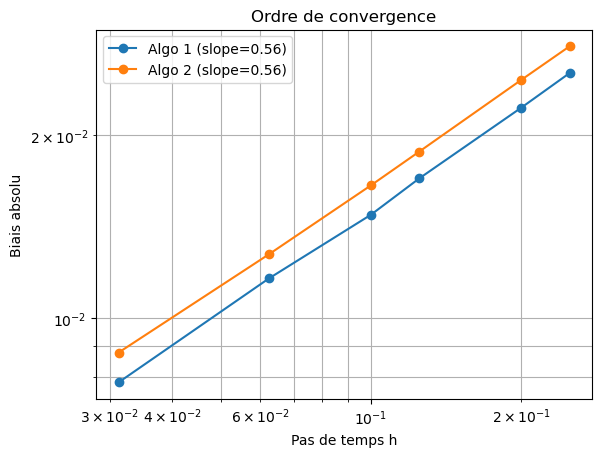

In [35]:
# log(h) vs log(bias)
import numpy as np
from matplotlib import pyplot as plt

hs = np.array(hs)
bias1 = np.array(error1)
bias2 = np.array(error2)

slope1, _ = np.polyfit(np.log(hs), np.log(bias1), 1)
slope2, _ = np.polyfit(np.log(hs), np.log(bias2), 1)

print(f"Ordre algo 1 ≈ {abs(slope1):.2f}")
print(f"Ordre algo 2 ≈ {abs(slope2):.2f}")

# Affichage
plt.loglog(hs, bias1, 'o-', label=f"Algo 1 (slope={abs(slope1):.2f})")
plt.loglog(hs, bias2, 'o-', label=f"Algo 2 (slope={abs(slope2):.2f})")
plt.xlabel("Pas de temps h")
plt.ylabel("Biais absolu")
plt.grid(True, which="both")
plt.legend()
plt.title("Ordre de convergence")
plt.show()

In [36]:
total_rebonds = b.sum()
chemins_rebondés = np.count_nonzero(b > 0)
ratio_rebondés = chemins_rebondés / len(b)

print("Nombre total de rebonds :", total_rebonds)
print("Proportion de chemins avec rebonds :", f"{100*ratio_rebondés:.2f}%")

Nombre total de rebonds : 128016.0
Proportion de chemins avec rebonds : 8.83%


In [37]:
prices1, exits1, b, ko = algo1_numba(L0, sigma, delta, K, Rup, T0, 0.001,
                                     100_000, drift_mat, U)

In [39]:
print("prices :", np.mean(prices1))

prices : 0.1542913219241628


# Sensibility

On teste les différentes sensibilités en modifiant les paramètres Rup.

In [44]:
# ===== Paramètres ===========================================================
N       = 10
T0      = 10.0
delta   = 1.0
K       = 0.01
Rup     = 0.065 # 0.075
L0      = 0.05 * np.ones(N)
sigma   = 0.10 * np.ones(N)
beta    = 0.1

# ----- Corrélation & Cholesky ----------------------------------------------
times = T0 + delta * np.arange(N)
rho   = np.exp(-beta * np.abs(times[:, None] - times[None, :]))
U     = cholesky(rho, lower=False)

# ----- Matrice drift --------------------------------------------------------
full_mat  = rho * np.outer(sigma, sigma)
drift_mat = np.tril(full_mat)

In [45]:
price_ref, _, b, ko = algo1_numba(L0,sigma,delta,K,Rup,T0,0.001,
                                100_000,drift_mat,U)

In [46]:
price_ref = np.mean(price_ref)
price_ref

total_rebonds = b.sum()
chemins_rebondés = np.count_nonzero(b > 0)
ratio_rebondés = chemins_rebondés / len(b)

print("Nombre total de rebonds :", total_rebonds)
print("Proportion de chemins avec rebonds :", f"{100*ratio_rebondés:.2f}%")

Nombre total de rebonds : 29608.0
Proportion de chemins avec rebonds : 18.98%


In [47]:
price_ref

0.11141399857012761

In [48]:
# ===== Boucle de convergence ===============================================
hs      = [0.20,0.10,0.05]
#hs      = [0.0625,0.03125, 0.015, 0.0075]
n_paths = 1_000_000          # 1 M si machine costaud
rows    = []
error2  = []
error1  = []

# warm-up (compilation)
algo2_numba(L0,sigma,delta,K,Rup,T0,hs[0],1,drift_mat,U)

for h in tqdm(hs,desc="Convergence"):
    prices2, exits2 = algo2_numba(L0,sigma,delta,K,Rup,T0,h,
                                n_paths,drift_mat,U)
    mean2  = prices2.mean()
    stderr2= 1.96 * prices2.std(ddof=1)/np.sqrt(n_paths)
    err2   = abs(mean2-price_ref)
    error2.append(err2)
    rows.append(dict(h=h,
                     error=f"{err2:.2e} ± {stderr2:.2e}",
                     mean_exit=f"{exits2.mean():.2f}"))

df2 = pd.DataFrame(rows)
print("\nTable de convergence algo 2:\n")
print(df2)


# ===== Boucle de convergence ===============================================
rows    = []

# warm-up (compilation)
algo1_numba(L0,sigma,delta,K,Rup,T0,hs[0],1,drift_mat,U)

for h in tqdm(hs,desc="Convergence"):
    prices1, exits1, b, ko = algo1_numba(L0,sigma,delta,K,Rup,T0,h,
                                n_paths,drift_mat,U)
    mean1  = prices1.mean()
    stderr1= 1.96 * prices1.std(ddof=1)/np.sqrt(n_paths)
    err1   = abs(mean1-price_ref)
    error1.append(err1)
    rows.append(dict(h=h,
                     error=f"{err1:.2e} ± {stderr1:.2e}",
                     mean_exit=f"{exits1.mean():.2f}"))

df1 = pd.DataFrame(rows)
print("\nTable de convergence algo 1:\n")
print(df1)

Convergence: 100%|██████████| 3/3 [00:46<00:00, 15.62s/it]



Table de convergence algo 2:

      h                error mean_exit
0  0.20  3.61e-02 ± 1.56e-04      6.94
1  0.10  2.48e-02 ± 1.60e-04      7.50
2  0.05  1.74e-02 ± 1.61e-04      7.82


Convergence: 100%|██████████| 3/3 [00:49<00:00, 16.56s/it]


Table de convergence algo 1:

      h                error mean_exit
0  0.20  3.26e-02 ± 1.60e-04      7.02
1  0.10  2.18e-02 ± 1.62e-04      7.53
2  0.05  1.46e-02 ± 1.63e-04      7.84
